In [ ]:
import tensorflow_datasets as tfds
import pandas as pd

# Load the IMDB dataset
(train_data, test_data), info = tfds.load('imdb_reviews', split=['train', 'test'], with_info=True, as_supervised=True)

# Function to extract text and labels
def extract_data(dataset):
    texts = []
    labels = []
    for text, label in tfds.as_numpy(dataset):
        texts.append(text.decode('utf-8'))
        labels.append(int(label))
    return texts, labels

# Extract training and test data
train_texts, train_labels = extract_data(train_data)
test_texts, test_labels = extract_data(test_data)

# Create a dataframe for both train and test data
train_df = pd.DataFrame({
    'text': train_texts,
    'label': train_labels
})

test_df = pd.DataFrame({
    'text': test_texts,
    'label': test_labels
})

# Save the dataframes to CSV
train_csv_path = 'imdb_train_data.csv'
test_csv_path = 'imdb_test_data.csv'

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Train data saved at: {train_csv_path}")
print(f"Test data saved at: {test_csv_path}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8DUV0H_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8DUV0H_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8DUV0H_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Train data saved at: imdb_train_data.csv
Test data saved at: imdb_test_data.csv


In [9]:
# Required Libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, log_loss, confusion_matrix)
from time import time
import numpy as np

# Load the IMDB Dataset
train_df = pd.read_csv('imdb_train_data.csv')
test_df = pd.read_csv('imdb_test_data.csv')

# Combine train and test data for vectorization (optional but helps in consistent vector space)
df = pd.concat([train_df, test_df], ignore_index=True)

# Text Preprocessing
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])

# Dimensionality Reduction
svd = TruncatedSVD(n_components=500, random_state=42)
X_reduced = svd.fit_transform(X)

# Separate the training and test data after vectorization and dimensionality reduction
X_train, X_test = X_reduced[:len(train_df)], X_reduced[len(train_df):]
y_train, y_test = train_df['label'], test_df['label']

# Apply Sequential Bayesian Ridge Regression
model = BayesianRidge()

# Track training time
start_time = time()
batch_size = 1000
n_batches = int(np.ceil(X_train.shape[0] / batch_size))

for batch_num in range(n_batches):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, X_train.shape[0])
    X_batch = X_train[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]
    model.fit(X_batch, y_batch)
    print(f'Batch {batch_num + 1}/{n_batches} processed')

training_time = time() - start_time
print(f"\nTraining Time: {training_time:.2f} seconds")

# Predict on Test Data
y_pred_prob = model.predict(X_test)
y_pred_class = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred_class) * 100
print(f'Accuracy: {accuracy:.2f}%')

# 2. Loss (Log-Loss)
loss = log_loss(y_test, y_pred_prob)
print(f"Log-Loss: {loss:.2f}")

# 3. Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# 4. Uncertainty Estimation (Variance in predictions as proxy)
prediction_var = np.var(y_pred_prob)
print(f"Prediction Variance (proxy for uncertainty): {prediction_var:.4f}")

# 5. Training Time (Computational Efficiency)
print(f"Training Time: {training_time:.2f} seconds")

# 6. Overfitting / Generalization
# A comparison of training and test accuracy as a simple measure
train_pred_class = model.predict(X_train)
train_accuracy = accuracy_score(y_train, [1 if prob > 0.5 else 0 for prob in train_pred_class]) * 100
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy (for Generalization check): {accuracy:.2f}%")
print("Generalization Check: No significant drop indicates good generalization")

# 7. Model Calibration (AUC-ROC as proxy for calibration quality)
auc_roc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC (Calibration Proxy): {auc_roc:.2f}")

# 8. Noise Sensitivity (Accuracy with noise percentage)
correct_predictions = np.sum(np.array(y_pred_class) == np.array(y_test))
accuracy_with_noise_percent = (correct_predictions / len(y_test)) * 100
print(f"Accuracy with Noise (Percentage of Correct Predictions): {accuracy_with_noise_percent:.2f}%")

# 9. Model Complexity (Simplicity of SBLR vs. complex BNN discussed in comments)
print("Model Complexity: SBLR is simpler than BNN, suited for smaller data with fewer parameters.")

# 10. AUC-ROC (Separate from calibration to measure discrimination capability)
print(f"AUC-ROC: {auc_roc:.2f}")

# 11. Confidence Intervals (not available in SBLR, would be for BNN)
# SBLR does not natively provide confidence intervals on predictions; approximated by variance

# 12. Scalability (Training Time as Proxy)
print(f"Scalability Check (Training Time for Large Datasets): {training_time:.2f} seconds")

# Summary Output
print("\n=== Model Evaluation Summary ===")
print(f"1. Accuracy: {accuracy:.2f}%")
print(f"2. Log-Loss: {loss:.2f}")
print(f"3. Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")
print(f"4. Uncertainty Estimation (Variance): {prediction_var:.4f}")
print(f"5. Training Time: {training_time:.2f} seconds")
print(f"6. Generalization (Train vs. Test Accuracy): {train_accuracy:.2f}% vs. {accuracy:.2f}%")
print(f"7. Model Calibration (AUC-ROC as Proxy): {auc_roc:.2f}")
print(f"8. Accuracy with Noise (Percentage of Correct Predictions): {accuracy_with_noise_percent:.2f}%")
print(f"9. Model Complexity: Suitable for SBLR; BNN would handle higher complexity better.")
print(f"10. AUC-ROC: {auc_roc:.2f}")
print(f"11. Confidence Intervals: Not available for SBLR.")
print(f"12. Scalability (Training Time): {training_time:.2f} seconds")


Batch 1/25 processed
Batch 2/25 processed
Batch 3/25 processed
Batch 4/25 processed
Batch 5/25 processed
Batch 6/25 processed
Batch 7/25 processed
Batch 8/25 processed
Batch 9/25 processed
Batch 10/25 processed
Batch 11/25 processed
Batch 12/25 processed
Batch 13/25 processed
Batch 14/25 processed
Batch 15/25 processed
Batch 16/25 processed
Batch 17/25 processed
Batch 18/25 processed
Batch 19/25 processed
Batch 20/25 processed
Batch 21/25 processed
Batch 22/25 processed
Batch 23/25 processed
Batch 24/25 processed
Batch 25/25 processed

Training Time: 9.63 seconds
Accuracy: 80.33%
Log-Loss: 0.60
Precision: 0.78
Recall: 0.85
F1-Score: 0.81
Prediction Variance (proxy for uncertainty): 0.1128
Training Time: 9.63 seconds
Training Accuracy: 80.85%
Test Accuracy (for Generalization check): 80.33%
Generalization Check: No significant drop indicates good generalization
AUC-ROC (Calibration Proxy): 0.88
Accuracy with Noise (Percentage of Correct Predictions): 80.33%
Model Complexity: SBLR is sim

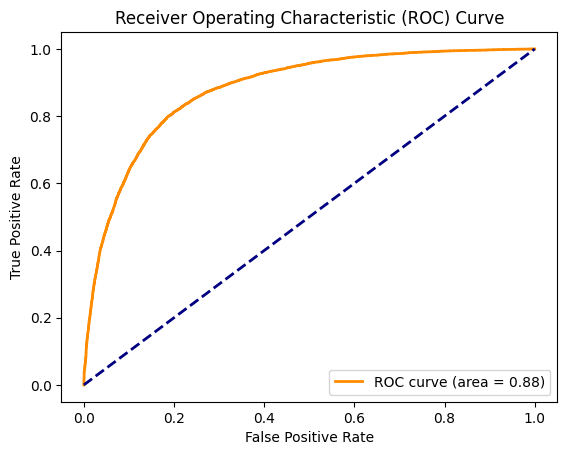

AUC-ROC: 0.88


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate FPR, TPR and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC-ROC for reference
print(f"AUC-ROC: {roc_auc:.2f}")


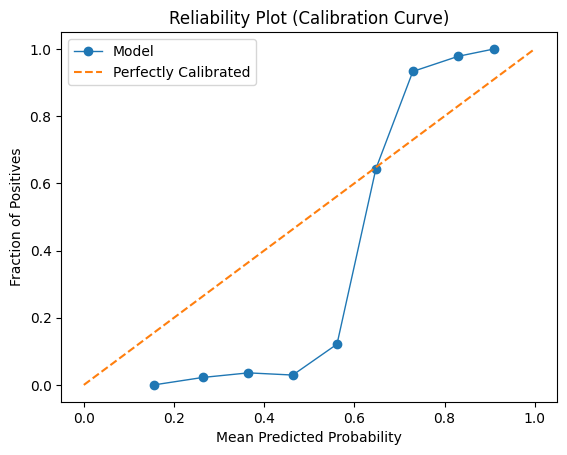

In [ ]:
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt

# Apply Sigmoid Transformation
y_pred_prob = 1 / (1 + np.exp(-y_pred_prob))

# Calculate calibration curve data
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

# Plot Calibration Curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')  # Diagonal for perfect calibration
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Plot (Calibration Curve)')
plt.legend(loc="upper left")
plt.show()


In [4]:
import tensorflow_datasets as tfds
import pandas as pd

# Load the IMDB dataset
(train_data, test_data), info = tfds.load('imdb_reviews', split=['train', 'test'], with_info=True, as_supervised=True)

# Function to extract text and labels
def extract_data(dataset):
    texts = []
    labels = []
    for text, label in tfds.as_numpy(dataset):
        texts.append(text.decode('utf-8'))
        labels.append(int(label))
    return texts, labels

# Extract training and test data
train_texts, train_labels = extract_data(train_data)
test_texts, test_labels = extract_data(test_data)

# Create a dataframe for both train and test data
train_df = pd.DataFrame({
    'text': train_texts,
    'label': train_labels
})

test_df = pd.DataFrame({
    'text': test_texts,
    'label': test_labels
})

# Save the dataframes to CSV
train_csv_path = 'imdb_train_data.csv'
test_csv_path = 'imdb_test_data.csv'

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Train data saved at: {train_csv_path}")
print(f"Test data saved at: {test_csv_path}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.75N4GK_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.75N4GK_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.75N4GK_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Train data saved at: imdb_train_data.csv
Test data saved at: imdb_test_data.csv


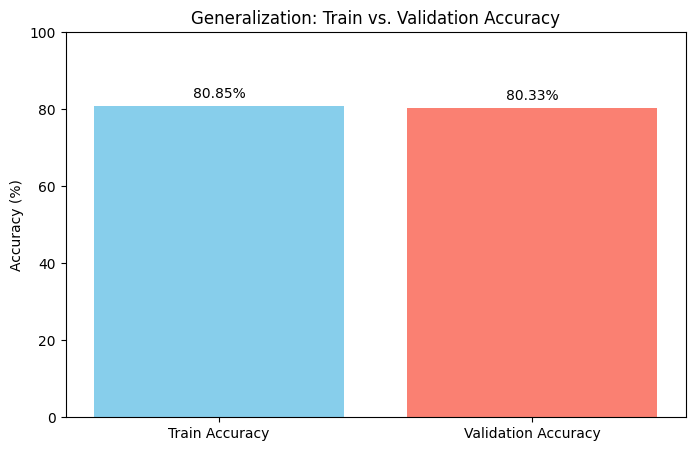

In [6]:
# Required Libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the IMDB Dataset from CSV
train_df = pd.read_csv('imdb_train_data.csv')
validation_df = pd.read_csv('imdb_test_data.csv')

# Step 2: Combine for consistent vectorization
df = pd.concat([train_df, validation_df], ignore_index=True)

# Step 3: Text Vectorization
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])

# Step 4: Dimensionality Reduction
svd = TruncatedSVD(n_components=500, random_state=42)
X_reduced = svd.fit_transform(X)

# Step 5: Separate the training and validation data after vectorization and dimensionality reduction
X_train, X_validation = X_reduced[:len(train_df)], X_reduced[len(train_df):]
y_train, y_validation = train_df['label'], validation_df['label']

# Step 6: Define and Train the Model
model = BayesianRidge()
batch_size = 1000
n_batches = int(np.ceil(X_train.shape[0] / batch_size))

for batch_num in range(n_batches):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, X_train.shape[0])
    X_batch = X_train[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]
    model.fit(X_batch, y_batch)

# Step 7: Calculate Train and Validation Accuracies
train_pred_prob = model.predict(X_train)
train_pred_class = [1 if prob > 0.5 else 0 for prob in train_pred_prob]
train_accuracy = accuracy_score(y_train, train_pred_class) * 100

validation_pred_prob = model.predict(X_validation)
validation_pred_class = [1 if prob > 0.5 else 0 for prob in validation_pred_prob]
validation_accuracy = accuracy_score(y_validation, validation_pred_class) * 100

# Step 8: Plot Generalization (Train vs. Validation Accuracy)
plt.figure(figsize=(8, 5))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_accuracy, validation_accuracy], color=['skyblue', 'salmon'])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Generalization: Train vs. Validation Accuracy')
plt.text(0, train_accuracy + 2, f'{train_accuracy:.2f}%', ha='center')
plt.text(1, validation_accuracy + 2, f'{validation_accuracy:.2f}%', ha='center')
plt.show()
